# Objective: Build a simple LSTM that can make time series predictions from the worm skeleton data 

In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import shutil
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset

plt.rcParams["figure.figsize"] = (35,5)
plt.rcParams.update({'font.size': 30})

ROOT = "/content/drive/My Drive/"

## Viewing and smooothening the curve to eliminate some noisy data points

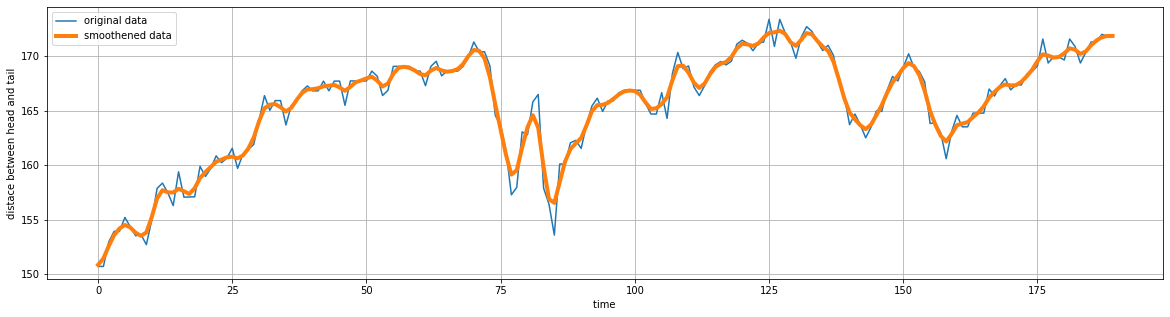

In [367]:
plt.rcParams["figure.figsize"] = (20,5)

df1 = pd.read_csv(ROOT + "time_series_data/" "distances_unc.csv")

all_data = df1.values[:190].flatten()
smooth_data = gaussian_filter1d(all_data, sigma = 1)

plt.plot(all_data, label = "original data")
plt.plot(smooth_data, linewidth = 4, label = "smoothened data")
plt.legend(fontsize= 10)
plt.xlabel("time ")
plt.ylabel("distace between head and tail")
plt.grid()
plt.show()

## Train test split for testing out the predictions later on 

In [324]:
test_data_size = 30
train_data = smooth_data[:-test_data_size +1]
test_data = smooth_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

161
30


## Scaling all the values to `[-1, 1]` 

In [325]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [326]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append([train_seq ,train_label])
    return inout_seq

In [327]:
train_window = 10
batch_size = 5
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_loader = DataLoader(train_inout_seq, batch_size = batch_size, shuffle = True)
print(len(train_loader), " batches of size ", batch_size)

31  batches of size  5


In [328]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=30, layers = 3, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers = layers )

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [346]:
num_layers = 4
model = LSTM(input_size=1, 
             hidden_layer_size=90, 
             layers = num_layers, 
             output_size=1
             )
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
print(model)

LSTM(
  (lstm): LSTM(1, 90, num_layers=4)
  (linear): Linear(in_features=90, out_features=1, bias=True)
)


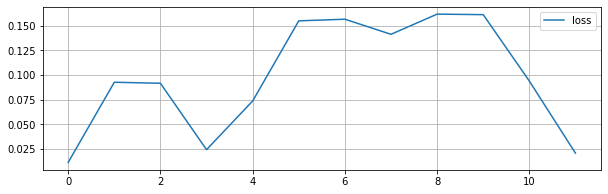

In [347]:
epochs = 12
losses = []
for i in range(epochs):
    for seq, labels in tqdm(train_inout_seq):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(num_layers,1, model.hidden_layer_size),
                        torch.zeros(num_layers,1, model.hidden_layer_size))

        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    losses.append(single_loss.item())

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

clear_output()
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(losses, label = "loss")
plt.grid()
plt.legend()
plt.show()

In [350]:
test_inputs = train_data_normalized[-train_window:].tolist()
preds = []

bound = len(test_inputs) 
num_future_preds = 10

model.eval()
for i in range(num_future_preds):
    seq = torch.FloatTensor(test_inputs[-train_window:])

    with torch.no_grad():
        model.hidden = (torch.zeros(num_layers, 1, model.hidden_layer_size),
                        torch.zeros(num_layers, 1, model.hidden_layer_size))
        pred = model(seq).item()

        preds.append(pred)
        test_inputs.append(pred)
        # print(seq, pred)

preds = np.array(preds)
test_inputs = np.array(test_inputs)
test_inputs = scaler.inverse_transform(test_inputs.reshape(-1,1))

preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = test_data[:num_future_preds]

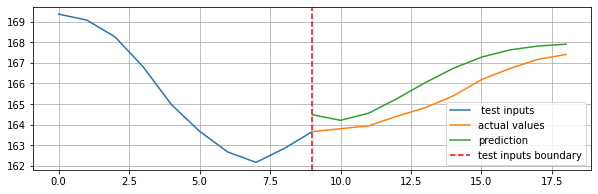

In [362]:
actual_axis = np.arange(bound -1, bound +len(actual) -1  )

plt.plot(test_inputs[:bound ], label = " test inputs")
plt.plot(actual_axis, actual, label = "actual values")
plt.plot(actual_axis, preds, label = "prediction")
plt.axvline(x = bound -1 , linestyle = "--", label = "test inputs boundary", c = "r")
plt.legend()
plt.grid()
plt.show()